## Generate mixture data

In [64]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

SEED = 383561
np.random.seed(SEED) # from random.org, for reproducibility

(array([0.0012079 , 0.00936123, 0.04378639, 0.11837423, 0.21862996,
        0.2726835 , 0.20896676, 0.11112683, 0.0884787 , 0.16004679,
        0.24580772, 0.32009359, 0.25577289, 0.13166114, 0.06341477,
        0.03261331, 0.04771206, 0.06190489, 0.07972142, 0.09180042,
        0.1102209 , 0.0957261 , 0.0933103 , 0.06341477, 0.04318244,
        0.02385603, 0.01509875, 0.00664345, 0.00271778, 0.0024158 ]),
 array([-1.80313378, -1.47198063, -1.14082747, -0.80967432, -0.47852117,
        -0.14736802,  0.18378513,  0.51493828,  0.84609143,  1.17724458,
         1.50839773,  1.83955089,  2.17070404,  2.50185719,  2.83301034,
         3.16416349,  3.49531664,  3.82646979,  4.15762294,  4.48877609,
         4.81992925,  5.1510824 ,  5.48223555,  5.8133887 ,  6.14454185,
         6.475695  ,  6.80684815,  7.1380013 ,  7.46915445,  7.80030761,
         8.13146076]),
 <a list of 30 Patch objects>)

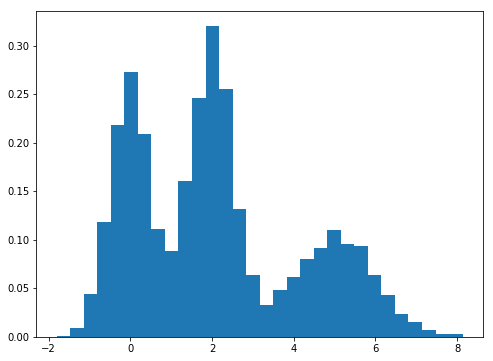

In [65]:
# Data Parameters
N = 10000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(x, bins=30, normed=True, lw=0)

In [9]:
# Sampling Parameters
N_SAMPLES = 2000
BURN_IN = 500
THINNING = 10

In [3]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [4]:
cb = [
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='absolute'),
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='relative'),
    ]

approx = pm.fit(
            random_seed=SEED,
            n=3, 
            method='advi', 
            model=model,
            callbacks=cb,
            obj_optimizer=pm.adagrad_window,
        )  # type: pm.MeanField
start = approx.sample(draws=1)[0]

Average Loss = 7,622.8: 100%|██████████| 3/3 [00:00<00:00, 471.85it/s]
Finished [100%]: Loss = 6,961.1


In [5]:
with model:
    _trace = pm.sample(N_SAMPLES, tune=BURN_IN, start=start, step_method=pm.NUTS, chains=2, njobs=2)
    trace = _trace[::THINNING]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_log__, mu, w_stickbreaking__]
100%|██████████| 2500/2500 [00:18<00:00, 136.53it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11149fcd0>,
      dtype=object)

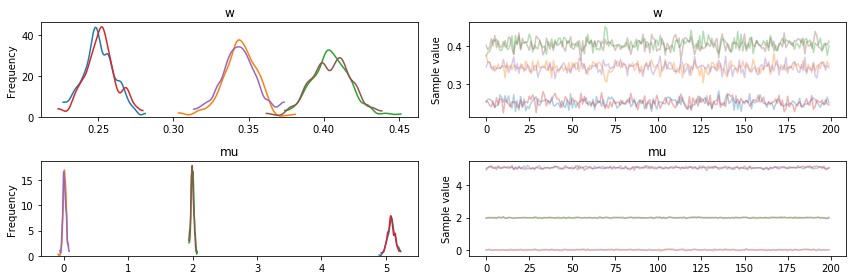

In [6]:
pm.traceplot(trace, varnames=['w', 'mu'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11173aa10>,
      dtype=object)

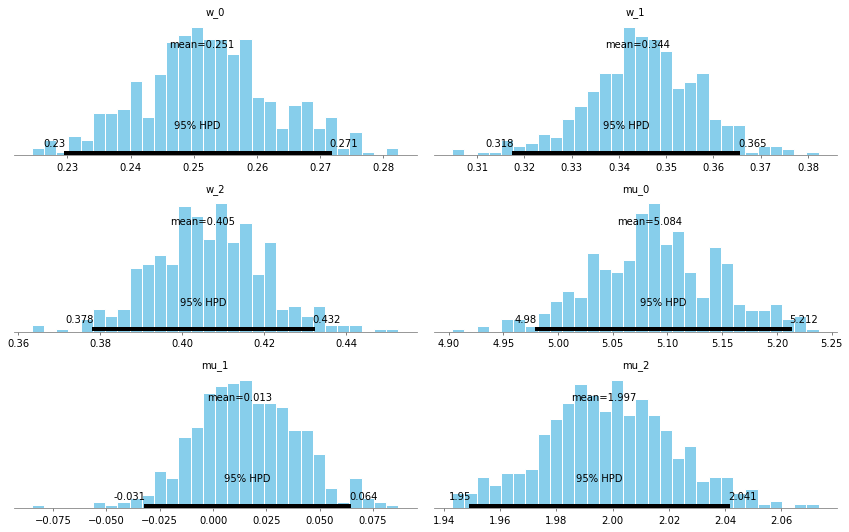

In [7]:
pm.plot_posterior(trace, varnames=['w', 'mu'])

100%|██████████| 5000/5000 [00:04<00:00, 1142.27it/s]


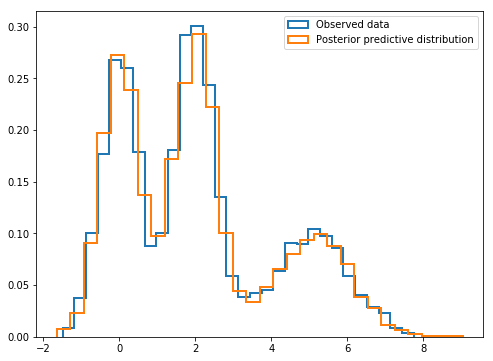

In [8]:
# We can also sample from the model’s posterior predictive distribution, as follows.
with model:
    ppc_trace = pm.sample_ppc(trace, 5000, random_seed=SEED)

# We see that the posterior predictive samples have a distribution quite close to that of the observed data.

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1)

## Run with SGFS

In [73]:
from collections import OrderedDict
import warnings

from pymc3.step_methods.arraystep import Competence, ArrayStepShared
from pymc3.vartypes import continuous_types
from pymc3.model import modelcontext, inputvars
import theano.tensor as tt
from pymc3.theanof import tt_rng, make_shared_replacements, jacobian, floatX, inputs
import theano
import numpy as np

__all__ = ['SGFS', 'CSG']

EXPERIMENTAL_WARNING = "Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet"\
    " recommended for use in PyMC3!"


def _value_error(cond, str):
    """Throws ValueError if cond is False"""
    if not cond:
        raise ValueError(str)


def _check_minibatches(minibatch_tensors, minibatches):
    _value_error(
        isinstance(minibatch_tensors, list),
        'minibatch_tensors must be a list.')

    _value_error(
        hasattr(minibatches, "__iter__"), 'minibatches must be an iterator.')


def get_model_hierarchy(model=None):
    """Calculates the hierarchichal relationships between variables
    
    Parameters
    ----------
    vars
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    hierarchy : dict
    """
    model = modelcontext(model)
    hierarchy = {}
    for rv in model.free_RVs:

        dist = None
        if hasattr(rv.distribution, 'transform_used') and rv.distribution.transform_used != None:
            dist = rv.distribution.dist
        else:
            dist = rv.distribution        

        inputs = []
        for var in model.named_vars.values():        
            if var in dist.__dict__.values() and hasattr(var, 'transformed'):
                inputs.append(var.transformed)
            elif var in dist.__dict__.values():
                inputs.append(var)

        hierarchy[rv] = inputs
    return hierarchy

def get_log_prior(vars=None, model=None):
    """Calculate the elementwise log-prior for the model.

    Parameters
    ----------
    vars
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    log_prior : [X]-D tensor
    """
    model = modelcontext(model)
    return tt.flatten(jacobian(tt.sum([v.logpt for v in vars]), vars))


def get_multi_obs_logp_elemwiset(vars=None, model=None):
    """Calculate the elementwise log-posterior for the model.
    Handle case when there are more than one observed RVs

    Parameters
    ----------
    model : PyMC Model
        Optional model. Default None, taken from context.
    Returns
    -------
    logp_elemwiset : array of shape (n_samples, n_observations)
        The contribution of the observations to the logp of the whole model.
    """
    model = modelcontext(model)
    cached = [(var, var.logp_elemwiset) for var in model.observed_RVs]

    if len(cached) == 0:
        return floatX(np.array([], dtype='d'))

    logp_elemwiset = []
    for var, logp in cached:
        if var.missing_values:
            logp = logp[~var.observations.mask]
        logp_elemwiset.append(logp.ravel())
        
    logp_elemwiset = tt.concatenate(logp_elemwiset, axis=1)
    return jacobian(logp_elemwiset, vars)


def get_elemwise_dlogL(vars=None, model=None, flat_view=None,):
    """
    Returns Jacobian of the log likelihood for each training datum wrt vars
    as a matrix of size N x D
    """
    # set model
    model = modelcontext(model)

    dlogp_elemwiset = get_multi_obs_logp_elemwiset(vars, model)    
    dlog_prior = get_log_prior(vars, model)        
    dlogL = dlogp_elemwiset + dlog_prior
    
    if flat_view is not None:
        
        dlogp_elemwiset = theano.clone(dlogp_elemwiset, flat_view.replacements, strict=False)
        dlog_prior = theano.clone(dlog_prior, flat_view.replacements, strict=False)
        dlogL = theano.clone(dlogL, flat_view.replacements, strict=False)

    return dlogp_elemwiset, dlog_prior, dlogL


class BaseStochasticGradient(ArrayStepShared):
    R"""
    BaseStochasticGradient Object

    For working with BaseStochasticGradient Object
    we need to supply the probabilistic model
    (:code:`model`) with the data supplied to observed
    variables of type `GeneratorOp`

    Parameters
    ----------
    vars : list
        List of variables for sampler
    batch_size`: int
        Batch Size for each step
    total_size : int
        Total size of the training data
    step_size : float
        Step size for the parameter update
    model : PyMC Model
        Optional model for sampling step. Defaults to None (taken from context)
    random_seed : int
        The seed to initialize the Random Stream
    minibatches : iterator
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
    minibatch_tensor : list of tensors
        If the ObservedRV.observed is not a GeneratorOp then this parameter must not be None
        The length of this tensor should be the same as the next(minibatches)

    Notes
    -----
    Defining a BaseStochasticGradient needs
    custom implementation of the following methods:
        - :code: `.mk_training_fn()`
            Returns a theano function which is called for each sampling step
        - :code: `._initialize_values()`
            Returns None it creates class variables which are required for the training fn
    """

    def __init__(self,
                 vars=None,
                 batch_size=None,
                 total_size=None,
                 step_size=None,
                 model=None,
                 random_seed=None,
                 minibatches=None,
                 minibatch_tensors=None,
                 **kwargs):
        warnings.warn(EXPERIMENTAL_WARNING)

        model = modelcontext(model)

        if vars is None:
            vars = model.vars

        vars = inputvars(vars)
        self.kwargs = kwargs
        self.model = model
        self.vars = vars
        self.batch_size = batch_size
        self.total_size = total_size
        _value_error(
            total_size != None or batch_size != None,
            'total_size and batch_size of training data have to be specified')
        self.expected_iter = int(total_size / batch_size)

        # set random stream
        self.random = None
        if random_seed is None:
            self.random = tt_rng()
        else:
            self.random = tt_rng(random_seed)
        
        if step_size is None:
            step_size = np.sqrt(float(batch_size) / total_size)
        
        self.step_size = step_size or 1.0

        shared = make_shared_replacements(vars, model)

        self.updates = OrderedDict()
        self.q_size = int(sum(v.dsize for v in self.vars))

        flat_view = model.flatten(vars)
        self.inarray = [flat_view.input]

        self.dlogp_elemwise, self.dlog_prior, self.dlogL_elemwise = get_elemwise_dlogL(vars, model, flat_view)
        
        self.q_size = int(sum(v.dsize for v in self.vars))

        if minibatch_tensors != None:
            _check_minibatches(minibatch_tensors, minibatches)
            self.minibatches = minibatches

            # Replace input shared variables with tensors
            def is_shared(t):
                return isinstance(t, theano.compile.sharedvalue.SharedVariable)

            tensors = [(t.type() if is_shared(t) else t)
                       for t in minibatch_tensors]
            updates = OrderedDict({
                t: t_
                for t, t_ in zip(minibatch_tensors, tensors) if is_shared(t)
            })
            self.minibatch_tensors = tensors
            self.inarray += self.minibatch_tensors
            self.updates.update(updates)

        self._initialize_values()
        super(BaseStochasticGradient, self).__init__(vars, shared)

    def _initialize_values(self):
        """Initializes the parameters for the stochastic gradient minibatch
        algorithm"""
        raise NotImplementedError

    def mk_training_fn(self):
        raise NotImplementedError

    def training_complete(self):
        """Returns boolean if astep has been called expected iter number of times"""
        return self.expected_iter == self.t

    def astep(self, q0):
        """Perform a single update in the stochastic gradient method.

        Returns new shared values and values sampled
        The size and ordering of q0 and q must be the same
        Parameters
        -------
        q0: list
            List of shared values and values sampled from last estimate

        Returns
        -------
        q
        """
        if hasattr(self, 'minibatch_tensors'):
            return q0 + self.training_fn(q0, *next(self.minibatches))
        else:
            return q0 + self.training_fn(q0)

class SGFS(BaseStochasticGradient):
    R"""
    StochasticGradientFisherScoring

    Parameters
    ----------
    vars : list
        model variables
    B : np.array
        the pre-conditioner matrix for the fisher scoring step
    step_size_decay : int
        Step size decay rate. Every `step_size_decay` iteration the step size reduce 
        to the half of the previous step size
 
    References
    ----------
    -   Bayesian Posterior Sampling via Stochastic Gradient Fisher Scoring
        Implements Algorithm 1 from the publication http://people.ee.duke.edu/%7Elcarin/782.pdf
    """
    name = 'stochastic_gradient_fisher_scoring'

    def __init__(self, vars=None, **kwargs):
        """
        Parameters
        ----------
        vars : list
            Theano variables, default continuous vars
        B : np.array
            Symmetric positive semi-definite Matrix
        kwargs: passed to BaseHMC
        """
        super(SGFS, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_I
        self.avg_I = theano.shared(
            np.zeros((self.q_size, self.q_size)), name='avg_I')
        self.t = theano.shared(1, name='t')
        # 2. Set gamma
        self.gamma = (self.batch_size + self.total_size) / (self.total_size)
        self.training_fn = self.mk_training_fn()
    
    def mk_training_fn(self):

        n = self.batch_size
        N = self.total_size
        q_size = self.q_size

        gamma = self.gamma
        avg_I = self.avg_I
        t = self.t
        updates = self.updates
        epsilon = self.step_size / (2 ** (t // 100))
        random = self.random
        inarray = self.inarray
        gt, dlog_prior = self.dlogL_elemwise, self.dlog_prior
        B = None
        
        # 5. Calculate mean dlogp
        avg_gt = gt.mean(axis=0)

        # 6. Calculate approximate Fisher Score
        gt_diff = (gt - avg_gt)

        V = (1. / (n - 1)) * tt.dot(gt_diff.T, gt_diff)

        # 7. Update moving average
        I_t = (1. - 1. / t) * avg_I + (1. / t) * V

        if B is None:
            # if B is not specified
            # B \propto I_t as given in
            # http://www.ics.uci.edu/~welling/publications/papers/SGFS_v10_final.pdf
            # after iterating over the data few times to get a good approximation of I_N
            B = tt.switch(t <= 100, tt.eye(q_size), gamma * I_t)

        # 8. Noise Term
        # The noise term is sampled from a normal distribution
        # of mean 0 and std_dev = sqrt(4B/step_size)
        # In order to generate the noise term, a standard
        # normal dist. is scaled with 2B_ch/sqrt(step_size)
        # where B_ch is cholesky decomposition of B
        # i.e. B = dot(B_ch, B_ch^T)
        B_ch = tt.slinalg.cholesky(B)
        noise_term = tt.dot((2.*B_ch)/tt.sqrt(epsilon), random.normal(size=(q_size,), dtype=theano.config.floatX))
        
        # 9.
        # Inv. Fisher Cov. Matrix
        cov_mat = (gamma * I_t * N) + ((4. / epsilon) * B)
        inv_cov_mat = tt.nlinalg.matrix_inverse(cov_mat)
        # Noise Coefficient
        noise_coeff = (dlog_prior + (N * avg_gt)) + noise_term
        dq = 2 * tt.dot(inv_cov_mat, noise_coeff)

        updates.update({avg_I: I_t, t: t + 1})

        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)
        
        return f

    @staticmethod
    def competence(var, has_grad):
        if var.dtype in continuous_types and has_grad:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE

In [76]:
dst = pm.distributions.LKJCholeskyCov.dist(n=step_method.q_size,
                                           eta=1.0, 
                                           sd_dist=tt.diagonal(step_method.gamma * step_method.avg_I))

In [ ]:
dst.

In [30]:
dst

In [10]:
(2 ** (200 // 100))

4

In [6]:
total_size

10000

In [66]:
batch_size = 500
x_minibatch = pm.Minibatch(x, batch_size=batch_size)
total_size = N * N_SAMPLES

with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x_minibatch)

In [67]:
cb = [
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='absolute'),
        pm.callbacks.CheckParametersConvergence(
            tolerance=1e-2, diff='relative'),
    ]

approx = pm.fit(
            random_seed=SEED,
            n=3, 
            method='advi', 
            model=model,
            callbacks=cb,
            obj_optimizer=pm.adagrad_window,
        )  # type: pm.MeanField
start = approx.sample(draws=1)[0]

Average Loss = 2,438.9: 100%|██████████| 3/3 [00:00<00:00, 463.60it/s]
Finished [100%]: Loss = 1,733.9


In [75]:
with model:
    step_method = CSG(batch_size=batch_size, total_size=total_size, step_size=1e-5)
    _trace = pm.sample(draws=N_SAMPLES, step=step_method, tune=BURN_IN, start=start, njobs=2)
    trace = _trace[::THINNING]

/Users/shashank/.virtualenvs/pymc3-dev/lib/python2.7/site-packages/ipykernel_launcher.py:179: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!


LinAlgError: 2-th leading minor of the array is not positive definite

# Test a few decay techniques

In [73]:
W, MU, SIGMA

(array([0.35, 0.4 , 0.25]), array([0., 2., 5.]), array([0.5, 0.5, 1. ]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12dd20750>,
      dtype=object)

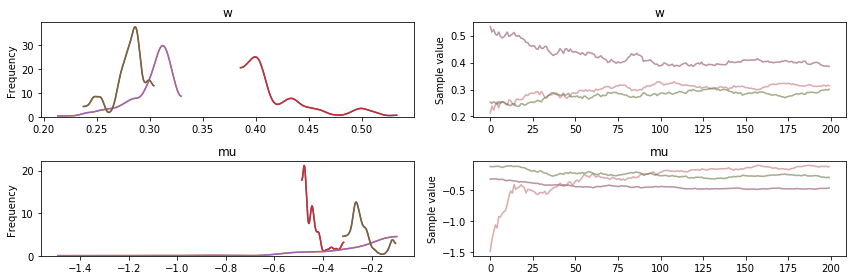

In [69]:
pm.traceplot(trace, varnames=['w', 'mu'])

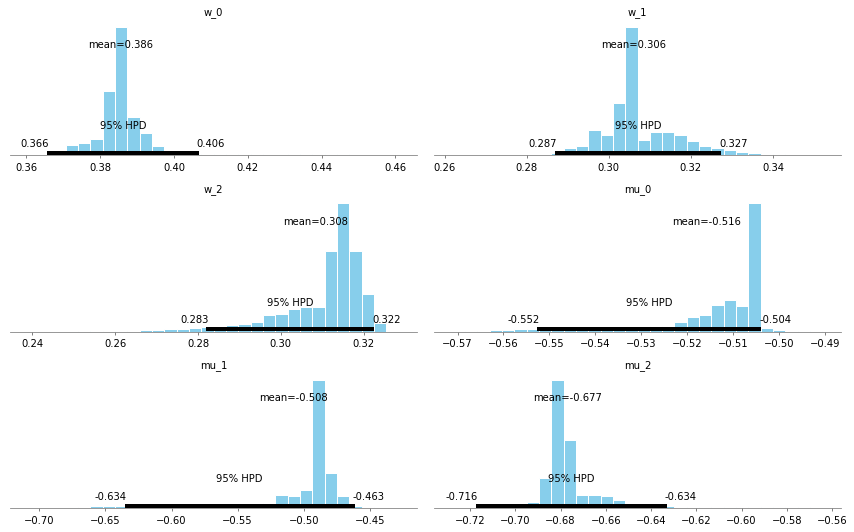

In [24]:
pm.plot_posterior(_trace, varnames=['w', 'mu']);

100%|██████████| 5000/5000 [00:03<00:00, 1309.01it/s]


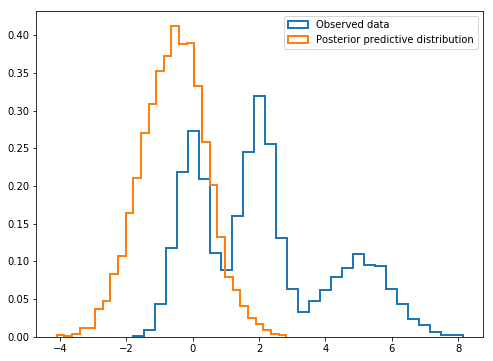

In [25]:
# We can also sample from the model’s posterior predictive distribution, as follows.
with model:
    ppc_trace = pm.sample_ppc(_trace, 5000, random_seed=SEED)

# We see that the posterior predictive samples have a distribution quite close to that of the observed data.

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1)

## Debugging

In [27]:
hierarchy = {}
for free_rv in model.free_RVs:
    hierarchy[free_rv] = [rv for rv in model.free_RVs if rv in free_rv.distribution.__dict__.values()]

print('How are variables connected?\n Each key in the dictionary maps a free rv to the variables it is dependent on.\n')
for idx, (key, value) in enumerate(hierarchy.items()):
    print("{}), {} -> {}".format(str(idx), str(key), str(value)))
print('\n')

gradient_wrt_beta = pm.theanof.jacobian1(f=logp_elem_model, v=model.beta)
res = gradient_wrt_beta.eval({model.mu: model.test_point['mu'],
                        model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                        model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                        model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                        model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                        model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                        model.alpha: model.test_point['alpha'],
                        model.beta: model.test_point['beta']})
res

How are variables connected?
 Each key in the dictionary maps a free rv to the variables it is dependent on.

0), w_stickbreaking__ -> []
1), mu -> []
2), tau_log__ -> []




NameError: name 'logp_elem_model' is not defined